# Assignment 4 - Neural Networks

## *Satvik Kishore*
Netid: sk741

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning objectives
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space to select optimized values.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

# 1

## [65 points] Exploring and optimizing neural network hyperparameters
Neural networks have become ubiquitous in the machine learning community, demonstrating exceptional performance over a wide range of supervised learning tasks. The benefits of these techniques come at a price of increased computational complexity and model designs with increased numbers of hyperparameters that need to be correctly set to make these techniques work. It is common that poor hyperparameter choices in neural networks result in significant decreases in model generalization performance. The goal of this exercise is to better understand some of the key hyperparameters you will encounter in practice using neural networks so that you can be better prepared to tune your model for a given application. Through this exercise, you will explore two common approaches to hyperparameter tuning a manual approach where we greedily select the best individual hyperparameter (often people will pick potentially sensible options, try them, and hope it works) as well as a random search of the hyperparameter space which as been shown to be an efficient way to achieve good hyperparameter values. 

To explore this, we'll be using the example data created below throughout this exercise and the various training, validation, test splits. We will select each set of hyperparameters for our greedy/manual approach and the random search using a training/validation split, then retrain on the combined training and validation data before finally evaluating our generalization performance for both our final models on the test data.

In [1]:
# Optional for clear plotting on Macs
# %config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with 
#  what's causing the warning and simply don't want to see it, we can use the 
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = 'ignore'
  
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import PredefinedSplit
from sklearn.neural_network import MLPClassifier
import seaborn as sb
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

In [2]:

#-----------------------------------------------------------------------------
# Create the data
#-----------------------------------------------------------------------------
# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    n_samples = int(n/4)
    shift = 0.5
    c1a = np.random.randn(n_samples,2)*noise + [-shift, shift]
    c1b = np.random.randn(n_samples,2)*noise + [shift, -shift]
    c0a = np.random.randn(n_samples,2)*noise + [shift, shift]
    c0b = np.random.randn(n_samples,2)*noise + [-shift, -shift]
    X = np.concatenate((c1a,c1b,c0a,c0b),axis=0)
    y = np.concatenate((np.ones(2*n_samples), np.zeros(2*n_samples)))
    
    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X)>cutoff
    for index,value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand()*2.5-1.25
    return (X,y)

# Training datasets
np.random.seed(42)
noise = 0.45
X_train,y_train = make_data_normal_checkerboard(500, noise=noise)
    
# Validation and test data
X_val,y_val = make_data_normal_checkerboard(500, noise=noise)
X_test,y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSeachCV, we will need to combine training and validation sets then
#  specify which portion is training and which is validation
# Also, for the final performance evaluation, train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate((-1*np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)

To help get you started we should always begin by visualizing our training data, here's some code that does that:

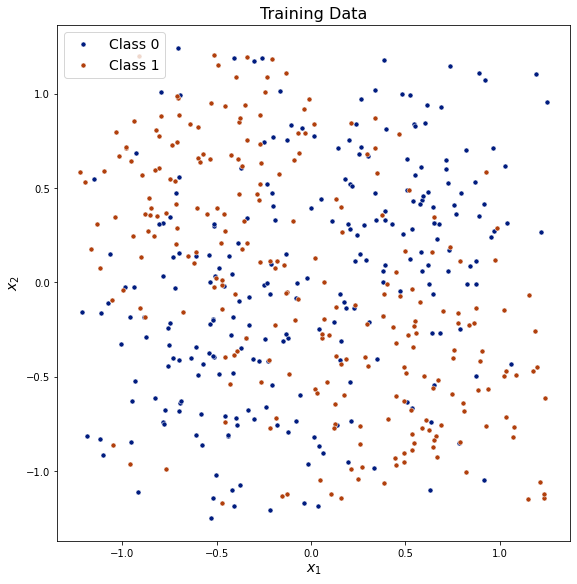

In [3]:
# Code to plot the sample data
def plot_data(ax,X,y,title, limits):
    # Select the colors to use in the plots
    # color0 = '#121619' # Dark grey
    # color1 = '#00B050' # Green
    color0 = sb.color_palette("dark",2)[0]
    color1 = sb.color_palette("dark",2)[1]
    color_boundary='#858585'
    
    # Separate samples by class
    samples0 = X[y==0]
    samples1 = X[y==1]

    ax.plot(samples0[:,0],samples0[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 0')
    ax.plot(samples1[:,0],samples1[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 1')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('$x_1$', fontsize=14)
    ax.set_ylabel('$x_2$', fontsize=14)
    ax.legend(loc='upper left', fontsize=14)
    ax.set_aspect('equal')

fig, ax = plt.subplots(constrained_layout=True, figsize=(8,8))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, 'Training Data', limits)

The hyperparameters we want to explore control the architecture of our model and how our model is fit to our data. These hyperparameters include the (a) learning rate, (b) batch size, and the (c) regularization coefficient, as well as the (d) model architecture hyperparameters (the number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem through this exercise. For all of the settings we'll explore and just, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.score) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

This default setting is our initial guess of what good values may be. Notice there are many model hyperparameters in this list: any of these could potentially be options to search over. We constrain the search to those hyperparameters that are known to have a significant impact on model performance.

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

In [4]:

np.random.seed(42069)
bg_cmap = ListedColormap(sb.color_palette("pastel"),N=2)
dot_cmap = sb.color_palette("dark",2)

flex = 0.5
h=0.02
xx, yy = np.meshgrid(np.arange(X_train[:,0].min() - flex,
                               X_train[:,0].max() + flex, h),
                     np.arange(X_train[:,1].min() - flex,
                               X_train[:,1].max() + flex, h))
gridshape = xx.shape
grid = np.c_[xx.ravel(), yy.ravel()]
grids = {'ravel': grid, 'xx':xx, 'yy':yy}

def mlp_trainplot(x, y, ax, grids, title, hls=(30,30), lr=0.03, reg=0, bs=None):
    if bs is None:
        bs = min(200, x.shape[0])
        pass
    model = MLPClassifier(hidden_layer_sizes = hls, learning_rate_init=lr, alpha=reg, batch_size=bs, 
                           solver="sgd", max_iter=500, n_iter_no_change = 1000, activation = 'relu',
                           early_stopping = False, tol = 1e-5)
    model.fit(x, y)
    gridpred = model.predict(grids['ravel']).reshape(grids['xx'].shape)
    
    
    ax.contourf(grids['xx'], grids['yy'], gridpred, cmap=bg_cmap)
    sb.scatterplot(x=x[:,0],  y=x[:,1], hue=y, ax=ax, palette=dot_cmap)
    ax.set_title(title, fontsize=14)
    return 0


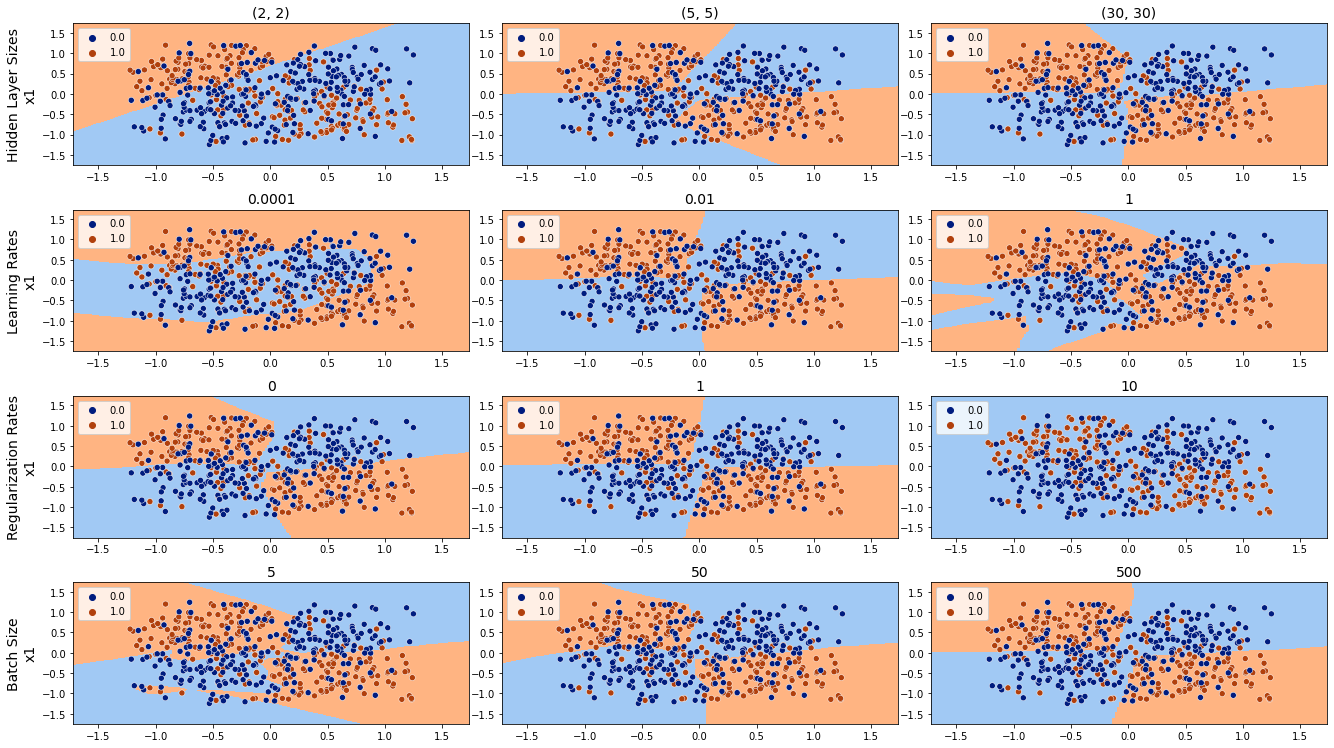

In [5]:
fig, axs = plt.subplots(4,3)
fs = 16
fig_scale = 1.
fig.set_size_inches(18.5*fig_scale, 10.5*fig_scale)
for i,hls in enumerate([(2,2), (5,5), (30,30)]):
    mlp_trainplot(X_train, y_train, ax=axs[0,i], grids=grids, title=str(hls), hls=hls)
axs[0,0].set_ylabel("Hidden Layer Sizes\nx1", fontsize=14)
for i,lr in enumerate([0.0001, 0.01, 1]):
    mlp_trainplot(X_train, y_train, ax=axs[1,i], grids=grids, title=str(lr), lr=lr)
axs[1,0].set_ylabel("Learning Rates\nx1", fontsize=14)
for i,reg in enumerate([0, 1, 10]):
    mlp_trainplot(X_train, y_train, ax=axs[2,i], grids=grids, title=str(reg), reg=reg)
axs[2,0].set_ylabel("Regularization Rates\nx1", fontsize=14)
for i,bs in enumerate([5, 50, 500]):
    mlp_trainplot(X_train, y_train, ax=axs[3,i], grids=grids, title=str(bs), bs=bs)
axs[3,0].set_ylabel("Batch Size\nx1", fontsize=14)
fig.tight_layout()

**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

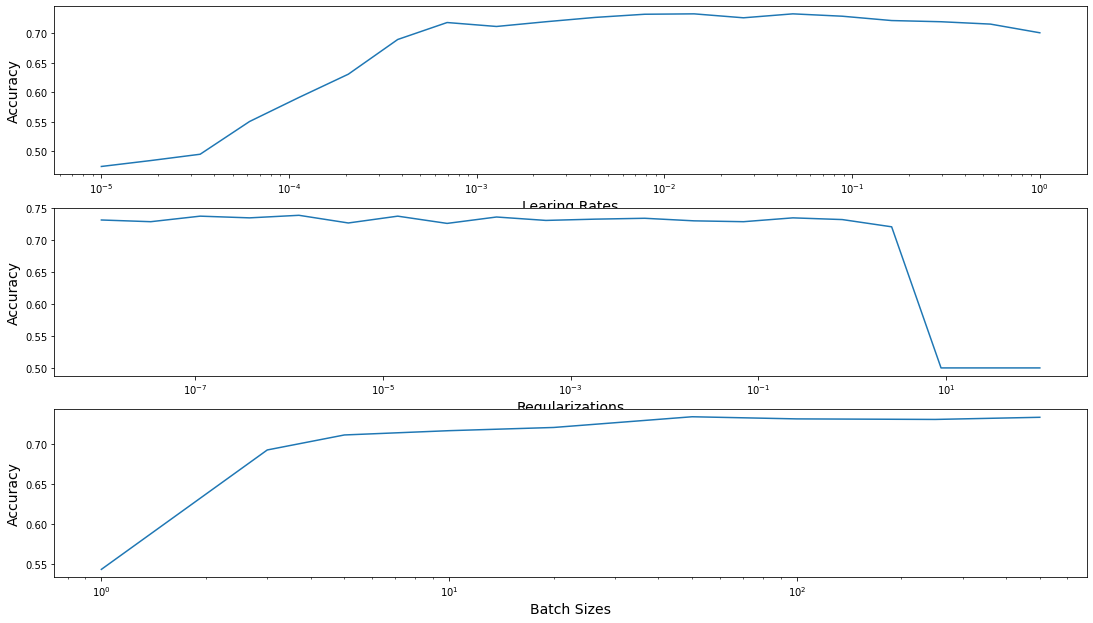

In [6]:
np.random.seed(69420)
n_samples = 3
lrs = np.logspace(-5,0,20)
regs = np.logspace(-8,2,20)
bss = [1,3,5,10,20,50,100,250,500]
lrscores = []
regscores = []
bsscores = []


fig, axs = plt.subplots(3,1)
fs = 16
fig_scale = 1.
fig.set_size_inches(18.5*fig_scale, 10.5*fig_scale)


for lr in lrs:
    temp = 0
    for ni in range(n_samples):
        model = MLPClassifier(hidden_layer_sizes = (30,30), learning_rate_init=lr, alpha=0, 
                               solver="sgd", max_iter=500, n_iter_no_change = 1000, activation = 'relu',
                               early_stopping = False, tol = 1e-5, )
        model.fit(X_train, y_train)
        temp += model.score(X_val, y_val)
    lrscores.append(temp/n_samples) 

axs[0].plot(lrs, lrscores)
axs[0].set_xlabel("Learing Rates", fontsize=14)
axs[0].set_ylabel("Accuracy", fontsize=14)
axs[0].set_xscale('log')

for reg in regs:
    temp = 0
    for ni in range(n_samples):
        model = MLPClassifier(hidden_layer_sizes = (30,30), learning_rate_init=0.03, alpha=reg, 
                               solver="sgd", max_iter=500, n_iter_no_change = 1000, activation = 'relu',
                               early_stopping = False, tol = 1e-5)
        model.fit(X_train, y_train)
        temp += model.score(X_val, y_val)
    regscores.append(temp/n_samples) 

axs[1].plot(regs, regscores)
axs[1].set_xlabel("Regularizations", fontsize=14)
axs[1].set_ylabel("Accuracy", fontsize=14)
axs[1].set_xscale('log')

for bs in bss:
    temp = 0
    for ni in range(n_samples):
        model = MLPClassifier(hidden_layer_sizes = (30,30), learning_rate_init=0.03, alpha=0, batch_size=bs,
                               solver="sgd", max_iter=500, n_iter_no_change = 1000, activation = 'relu',
                               early_stopping = False, tol = 1e-5)
        model.fit(X_train, y_train)
        temp += model.score(X_val, y_val)
    bsscores.append(temp/n_samples) 

axs[2].plot(bss, bsscores)
axs[2].set_xlabel("Batch Sizes", fontsize=14)
axs[2].set_ylabel("Accuracy", fontsize=14)
axs[2].set_xscale('log')

In [7]:
lroptim = lrs[np.argmax(lrscores)]
regoptim = regs[np.argmax(regscores)]
bsoptim = int(bss[np.argmax(bsscores)])
print("Best Learning Rate =", lroptim)
print("Best Alpha =",regoptim)
print("Best Batch Size =",bsoptim)

Best Learning Rate = 0.01438449888287663
Best Alpha = 1.2742749857031322e-06
Best Batch Size = 50


**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

In [8]:
def mlp_trainplot2(x, y, n_hl, hls):
    hl = tuple([hls for _ in range(n_hl)])
    model = MLPClassifier(hidden_layer_sizes = hl, learning_rate_init=lroptim, alpha=regoptim, batch_size=bsoptim, 
                       solver="sgd", max_iter=500, n_iter_no_change = 1000, activation = 'relu',
                       early_stopping = False, tol = 1e-5)
    model.fit(x, y)
    return model.score(X_val, y_val)

heat = np.zeros((9,4))
n_hl_l = [1,2,3,4]
hls_l = [1,2,3,4,5,10,15,25,30]

for i,n_hl in enumerate(n_hl_l):
    for j,hls in enumerate(hls_l):
        heat[j,i] = mlp_trainplot2(X_train, y_train, n_hl, hls)
        
        

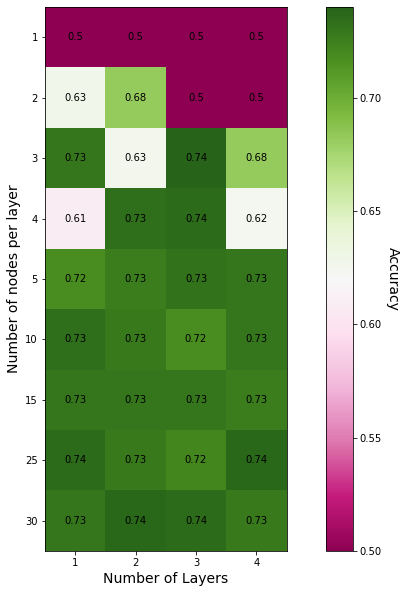

In [9]:
fig, ax = plt.subplots(figsize = (14,10))
im = ax.imshow(heat, cmap= "PiYG")
for j in range(len(n_hl_l)):
    for i in range(len(hls_l)):
        text = ax.text(j, i, round(heat[i, j], 2),
                       ha="center", va="center", color="black")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Accuracy", rotation=-90, va="bottom", fontsize=14)
ax.set_xticks(range(4))
ax.set_yticks(range(len(hls_l)))
ax.set_xticklabels(n_hl_l)
ax.set_yticklabels(hls_l)
ax.set_xlabel("Number of Layers", fontsize=14)
ax.set_ylabel("Number of nodes per layer", fontsize=14)
None

The best accuracy found was 0.74. Many architectures here are able to reach this score, but we observe that this score is reached more reliably when model complexity is increased. Trading off between model complexity and reaching this high score reliably, 2 hidden layers with 10 nodes each appears to be reasonable choice

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

In [10]:
n_layer_optim = 2
n_node_optim = 10
model_gridsearch = MLPClassifier(hidden_layer_sizes = (n_node_optim)*n_layer_optim, learning_rate_init=lroptim, alpha=regoptim, batch_size=bsoptim, 
                    solver="sgd", max_iter=500, n_iter_no_change = 1000, activation = 'relu',
                    early_stopping = False, tol = 1e-5)
model_gridsearch.fit(X_train_plus_val, y_train_plus_val)
accuracy = model_gridsearch.score(X_test, y_test)


#plot_roc_curve(model_gridsearch, X_test, y_test)
print("Test Accuracy = ", round(accuracy,2))

Test Accuracy =  0.72


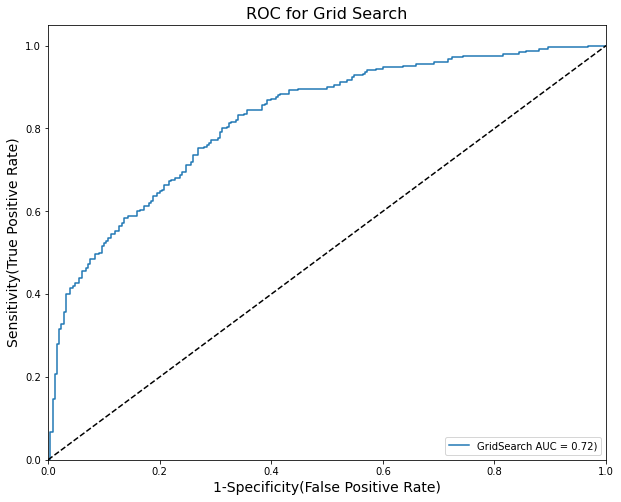

In [11]:
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, model_gridsearch.predict_proba(X_test)[:,1])
auc_gs = roc_auc_score(y_test,model_gridsearch.predict(X_test))

fig,ax = plt.subplots(1, figsize=(10,8))
ax.plot(fpr_gs, tpr_gs, label='GridSearch AUC = %0.2f)' % auc_gs)
ax.plot([0, 1], [0, 1],'r--', color='black')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1-Specificity(False Positive Rate)', fontsize=14)
ax.set_ylabel('Sensitivity(True Positive Rate)', fontsize=14)
ax.set_title('ROC for Grid Search', fontsize=16)
ax.legend(loc="lower right")


**(e)** **Automated hyperparameter search through random search**. The manual (greedy) approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it is limited in one very problematic way: it depends heavily on a good "default" setting of the hyperparameters. Those were provided for you in this exercise, but are not generally know. Our manual optimization was somewhat greedy because we picked the hyperparameters one at a time rather than looking at different combinations of hyperparameters. Adopting such a pseudo-greedy approach to that manual optimization also limits our ability to more deeply search the hyperparameter space since we don't look at simultaneous changes to multiple parameters. Now we'll use a popular hyperparameter optimization tool to accomplish that: random search.

Random search is an excellent example of a hyperparameter optimization search strategy that has [been shown to be more efficient](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a?ref=https://githubhelp.com) (requiring fewer training runs) than another common approach: grid search. Grid search evaluates all possible combinations of hyperparameters from lists of possible hyperparameter settings - a very computationally expensive process. Yet another attractive alternative is [Bayesian Optimization](https://arxiv.org/abs/1807.02811), which is an excellent hyperparameter optimization strategy but we will leave that to the interested reader.

Our particular random search tool will be Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This performs random search employing cross validation for performance evaluation (we will adjust this to ve a train/validation split). 

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this.
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to.
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset
- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve
- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary
- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

In [12]:

model = MLPClassifier(hidden_layer_sizes = (n_node_optim)*n_layer_optim, learning_rate_init=lroptim, alpha=regoptim, batch_size=bsoptim, 
                    solver="sgd", max_iter=500, n_iter_no_change = 1000, activation = 'relu',
                    early_stopping = False, tol = 1e-5)
all_archi = [(j,)*i for i in n_hl_l for j in hls_l]
param_dist = {
    "batch_size": bss,
    "learning_rate_init": loguniform(1e-5, 1e0),
    "alpha": loguniform(1e-8, 1e2 ),
    "hidden_layer_sizes": all_archi,
}
rvsearcher = RandomizedSearchCV(estimator = model, 
                               param_distributions = param_dist,
                               n_iter = 200,
                               n_jobs= -1,
                               cv = train_val_split)
rvout = rvsearcher.fit(X_train_plus_val, y_train_plus_val)

In [13]:
print("The best parameters were found to be:")
print(rvout.best_params_)

The best parameters were found to be:
{'alpha': 1.781312249804196e-05, 'batch_size': 500, 'hidden_layer_sizes': (5, 5, 5), 'learning_rate_init': 0.011040661345789172}


In [14]:
model_randomoptim = MLPClassifier(hidden_layer_sizes = rvout.best_params_['hidden_layer_sizes'], learning_rate_init=rvout.best_params_['learning_rate_init'], alpha=rvout.best_params_['alpha'], batch_size=rvout.best_params_['batch_size'], 
                    solver="sgd", max_iter=500, n_iter_no_change = 1000, activation = 'relu',
                    early_stopping = False, tol = 1e-5) 
model_randomoptim.fit(X_train_plus_val, y_train_plus_val)



MLPClassifier(alpha=1.781312249804196e-05, batch_size=500,
              hidden_layer_sizes=(5, 5, 5),
              learning_rate_init=0.011040661345789172, max_iter=500,
              n_iter_no_change=1000, solver='sgd', tol=1e-05)

Test Accuracy for random search=  0.73


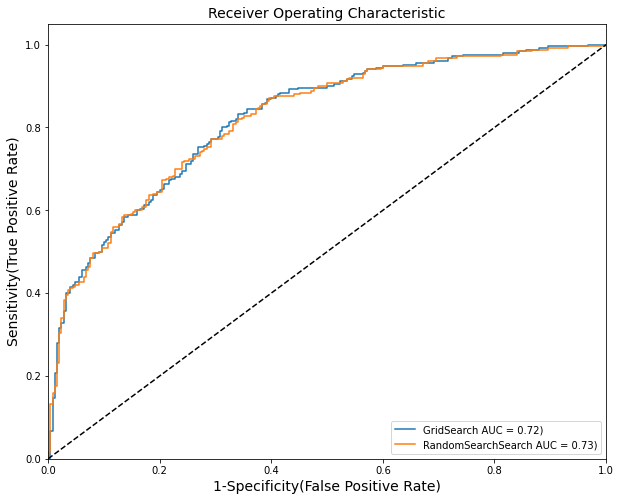

In [15]:
fpr_rs, tpr_rs, thresholds_rs = roc_curve(y_test, model_randomoptim.predict_proba(X_test)[:,1])
auc_rs = roc_auc_score(y_test,model_randomoptim.predict(X_test))

fig,ax = plt.subplots(1, figsize=(10,8))
ax.plot(fpr_gs, tpr_gs, label='GridSearch AUC = %0.2f)' % auc_gs)
ax.plot(fpr_rs, tpr_rs, label='RandomSearchSearch AUC = %0.2f)' % auc_rs)
ax.plot([0, 1], [0, 1],'r--', color='black')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1-Specificity(False Positive Rate)', fontsize=14)
ax.set_ylabel('Sensitivity(True Positive Rate)', fontsize=14)
ax.set_title('Receiver Operating Characteristic', fontsize=14)
ax.legend(loc="lower right")

accuracy = model_randomoptim.score(X_test, y_test)
print("Test Accuracy for random search= ", round(accuracy,2))

The model performance of the randomsearch was appromately the same as our model with optimzied through grid search. Both architectures use 5 nodes per layer, however we chose 2 layers from grid search wheras randomserach suggests 3. 

Text(0.5, 1.0, 'RandomSearch Decision Boundary')

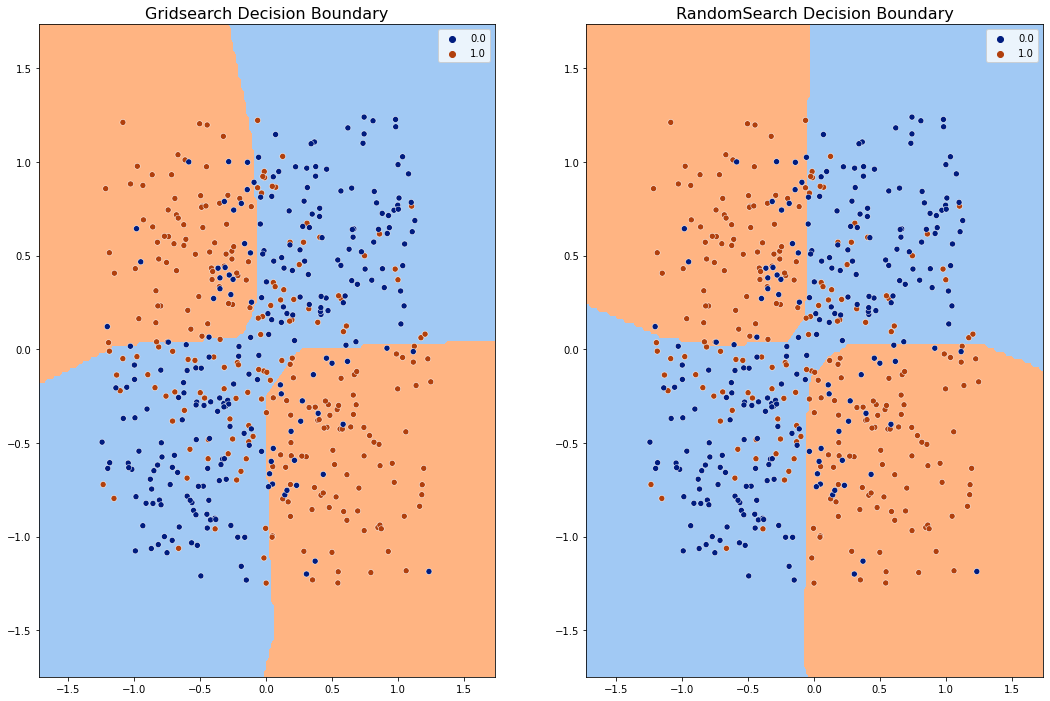

In [16]:
fig,axs = plt.subplots(1,2, figsize=(18,12))
gridpred = model_gridsearch.predict(grids['ravel']).reshape(grids['xx'].shape)
    
axs[0].contourf(grids['xx'], grids['yy'], gridpred, cmap=bg_cmap)
sb.scatterplot(x=X_test[:,0],  y=X_test[:,1], hue=y_test, ax=axs[0], palette=dot_cmap)
axs[0].set_title("Gridsearch Decision Boundary", fontsize=16)

gridpred = model_randomoptim.predict(grids['ravel']).reshape(grids['xx'].shape)
    
axs[1].contourf(grids['xx'], grids['yy'], gridpred, cmap=bg_cmap)
sb.scatterplot(x=X_test[:,0],  y=X_test[:,1], hue=y_test, ax=axs[1], palette=dot_cmap)
axs[1].set_title("RandomSearch Decision Boundary", fontsize=16)

# 2

## [25 points] Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a) [OPTIONAL - 10 BONUS POINTS]** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). I strongly recommend the use of VS Code and the Python debugging tools in that development environment.
- *Unit tests*. You are strongly encouraged to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar for similar parameter settings).

**NOTE: if you choose not to build your own neural network, then use the `scikit-learn` implementation instead in the questions below; where it asks to compare to `scikit-learn`, compare against a random forest classifier instead**

**(b)** Apply your neural network. 
- Create a training and validation dataset using `sklearn.datasets.make_moons(N, noise=0.20)`, where $N_{train} = 500$ and $N_{test} = 100$. 
- Train and test your model on this dataset plotting your learning curves (training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time). 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. 
- In two subplots, plot the training data on one subplot, and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- Report your performance on the test data with an ROC curve and compare against the `scikit-learn` `MLPClassifier` trained with the same parameters.

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

**(a)**

In [17]:

class myNeuralNetwork(object):
    
    def __init__(self, n_in, n_layer1, n_layer2, learning_rate=0.01, lossfunc="cross_entropy", bias=False):
        '''__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs, 
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        '''
        self.lossfunc = lossfunc
        self.lr  = learning_rate
        if bias is True:
            n_in += 1
        #n_params = 1
        self.w1 = np.random.randn(n_in, n_layer1) 
        self.w2 = np.random.randn(n_layer1, n_layer2)
        self.w3 = np.random.randn(n_layer2, 1)
        
        self.w1_grad = np.zeros_like(self.w1)
        self.w2_grad = np.zeros_like(self.w2)
        self.w3_grad = np.zeros_like(self.w2)
        self.y_hat = np.zeros((1,1))
        self.a2 = np.zeros((n_layer2, 1))
        self.a1 = np.zeros((n_layer1, 1))
        self.a3_grad = np.zeros_like(self.y_hat)
        self.a2_grad = np.zeros_like(self.a2)
        self.a1_grad = np.zeros_like(self.a1)
        
    def add_bias(self, x):
        return np.c_[np.ones(x.shape[0]), x]
    
    def add_bias_single(self, x):
        return np.append(1, x)

    def forward_propagation(self, x, bias=False):
        '''forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        '''
        if bias is True:
            x = self.add_bias_single(x)
        x = self.sigmoid(self.w1.T @ x)
        x = self.sigmoid(self.w2.T @ x)
        x = self.sigmoid(self.w3.T @ x)
        return x
    
    def compute_loss(self, X, y, bias=False):
        '''compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        '''
        if bias is True:
            X = self.add_bias(X)
        y_hat = np.array([self.forward_propagation(X[i,:]) for i in range(X.shape[0]) ]).reshape(-1)
        return self.loss_func(y, y_hat, single=False)

    def backpropagate(self, x, y, bias=False):
        '''backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations 
               Corresponding to x and get the loss functionof the model 
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network
    
            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        '''

        if bias is True:
            x = self.add_bias_single(x)
        x = x.reshape(-1,1)
        self.a1 = self.sigmoid(self.w1.T @ x).reshape(-1,1)
        self.a2 = self.sigmoid(self.w2.T @ self.a1).reshape(-1,1)
        self.y_hat = self.sigmoid(self.w3.T @ self.a2)
        L = self.loss_func(y, self.y_hat, single=True)
        self.a3_grad = self.loss_grad(y, self.y_hat).reshape(-1,1)
        self.a2_grad = self.a3_grad * self.sigmoid_derivative(self.w3.T @ self.a2) * self.w3
        self.w3_grad = self.a3_grad * self.sigmoid_derivative(self.w3.T @ self.a2) * self.a2
        self.w2_grad = ( self.a1 @ self.a2_grad.T ) * self.sigmoid_derivative(self.w2 * self.a1)
        self.a1_grad = ( self.sigmoid_derivative(self.w2.T @ self.a1).reshape(1,-1) * self.w2 ) @ self.a2_grad
        self.w1_grad = x @ self.a1_grad.T * self.sigmoid_derivative(self.w1 * x)
        return L


    def stochastic_gradient_descent_step(self):
        '''stochastic_gradient_descent_step [OPTIONAL - you may also do this
        directly in backpropagate]
        Using the gradient values computed by backpropagate, update each
        weight value of the model according to the familiar stochastic
        gradient descent update equation.
        
        Input: none
        Output: none
        '''
        self.w1 -= self.w1_grad*self.lr
        self.w2 -= self.w2_grad*self.lr
        self.w3 -= self.w3_grad*self.lr
    
    def fit(self, X, y, max_epochs=1, val_X=None, val_y=None, record_rmsgrads=False, bias=False):
        '''fit
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                training_loss:   Vector of training loss values at the end of each epoch
                validation_loss: Vector of validation loss values at the end of each epoch
                                 [optional output if get_validation_loss==True]
        '''
        if bias is True:
            X = self.add_bias(X)
            if val_X is not None:
                val_X = self.add_bias(val_X)
        training_loss = []
        val_loss = []
        if record_rmsgrads:
            rms_grads = []
        for e in range(max_epochs):
            shuffle = np.random.choice(X.shape[0], X.shape[0], replace = False)
            X_shuffle = X[shuffle]
            y_shuffle = y[shuffle]
            for i in range(X.shape[0]):
                self.backpropagate(X_shuffle[i,:], y_shuffle[i])
                self.stochastic_gradient_descent_step()
                pass
            training_loss.append(self.compute_loss(X_shuffle, y_shuffle))
            if val_X is not None and val_y is not None:
                val_loss.append(self.compute_loss(val_X, val_y))
                pass
            if record_rmsgrads:
                rms_grads.append(self.rmsgrad())
            pass
        outdict =  {'training_loss': training_loss, 'val_loss': val_loss}
        if record_rmsgrads:
            outdict['rms_grads'] = rms_grads
        return outdict

    def loss_func(self, y,y_hat,single):
        if self.lossfunc == "rmse":
            if single is True:
                return 0.5*((y-y_hat)**2)
            else:
                return ((y-y_hat)**2).mean()*0.5
        else:
            if single is True:
                return - y*np.log(self.y_hat) - (1-y)*np.log(1-self.y_hat)
            else:
                return np.mean(- y*np.log(y_hat) - (1-y)*np.log(1-y_hat))

    def loss_grad(self, y, y_hat):
        if self.lossfunc == "rmse":
            return y_hat - y
        else:
            return (1-y)/(1-self.y_hat) - y/self.y_hat

    def predict_proba(self, X, bias=False):
        '''predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        '''
        if bias is True:
            X = self.add_bias(X)
        return np.array([self.forward_propagation(X[i,:]) for i in range(X.shape[0])]).reshape(-1)

    def predict(self, X, decision_thresh=0.5, bias=False):
        '''predict
        Compute the output of the neural network prediction for 
        each sample in X, with the last layer's sigmoid activation 
        providing an estimate of the target output between 0 and 1, 
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        '''
        if bias is True:
            X = self.add_bias(X)
        y_hat = self.predict_proba(X)
        return (y_hat > decision_thresh).astype(float).reshape(-1,)

    def sigmoid(self, X):
        '''sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        '''
        return 1 / (1 + np.exp(-X) )
    
    def sigmoid_derivative(self, X):
        '''sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        '''
        return self.sigmoid(X) * self.sigmoid(-X)

    def rmsgrad(self):
        return (self.w1_grad**2).mean() 


**(b)**

In [18]:

noise = 0.20
x_train, yy_train = make_moons(400, noise=noise)
x_val, yy_val = make_moons(100, noise=noise)
x_test, yy_test = make_moons(100, noise=noise)

In [35]:
np.random.seed(121)
n_epochs = 400
mynn = myNeuralNetwork(n_in=2, n_layer1=9, n_layer2=9, learning_rate=0.02,
                       lossfunc="cross_entropy", bias=True)
fit_results = mynn.fit(x_train, yy_train, max_epochs=n_epochs,val_X=x_val, val_y=yy_val, bias=True)

Text(0, 0.5, 'Softmax Loss')

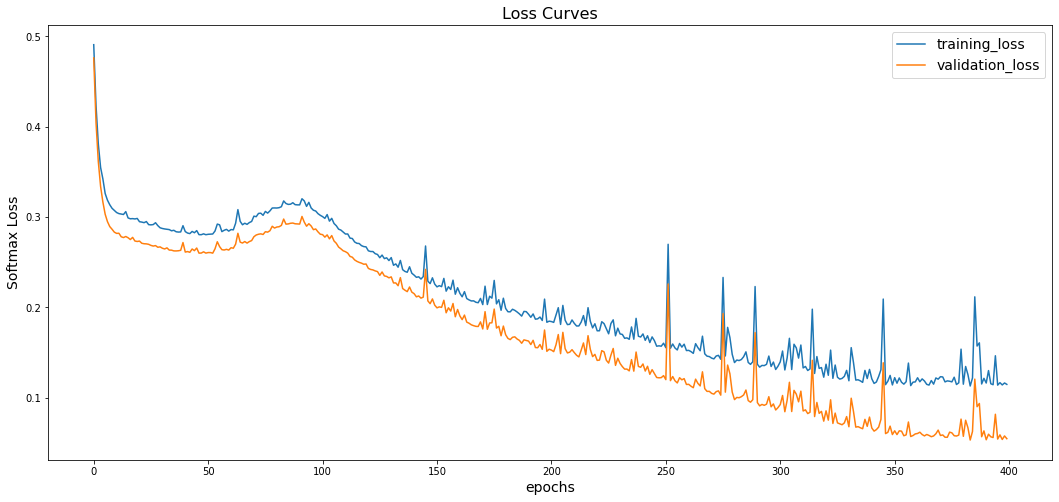

In [36]:

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(range(n_epochs), fit_results['training_loss'], label='training_loss')
ax.plot(range(n_epochs), fit_results['val_loss'], label='validation_loss')
ax.legend(fontsize=14)
ax.set_title("Loss Curves", fontsize = 16)
ax.set_xlabel("epochs", fontsize = 14)
ax.set_ylabel("Softmax Loss", fontsize = 14)


Text(0, 0.5, 'x1')

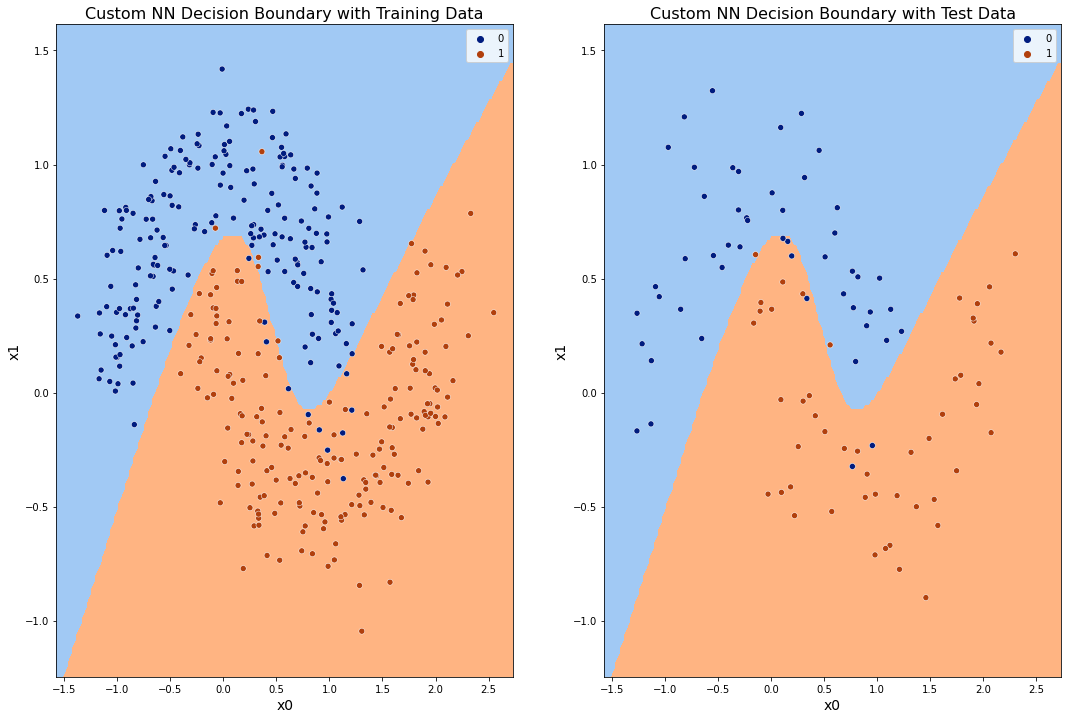

In [37]:
flex = 0.2
h=0.02
xx, yy = np.meshgrid(np.arange(x_train[:,0].min() - flex,
                               x_train[:,0].max() + flex, h),
                     np.arange(x_train[:,1].min() - flex,
                               x_train[:,1].max() + flex, h))
gridshape = xx.shape
grid = np.c_[xx.ravel(), yy.ravel()]
grids = {'ravel': grid, 'xx':xx, 'yy':yy}
gridpred = mynn.predict(grids['ravel'], bias=True).reshape(grids['xx'].shape)

bg_cmap = ListedColormap(sb.color_palette("pastel"),N=2)
dot_cmap = sb.color_palette("dark",2)
fig, ax = plt.subplots(1,2, figsize=(18,12))
ax[0].contourf(grids['xx'], grids['yy'], gridpred, cmap=bg_cmap)
ax[1].contourf(grids['xx'], grids['yy'], gridpred, cmap=bg_cmap)
sb.scatterplot(x=x_train[:,0],  y=x_train[:,1], hue=yy_train, ax=ax[0], palette=dot_cmap)
sb.scatterplot(x=x_test[:,0],  y=x_test[:,1], hue=yy_test, ax=ax[1], palette=dot_cmap)
ax[0].set_title("Custom NN Decision Boundary with Training Data", fontsize = 16)
ax[1].set_title("Custom NN Decision Boundary with Test Data", fontsize = 16)
ax[0].set_xlabel("x0", fontsize = 14)
ax[0].set_ylabel("x1", fontsize = 14)
ax[1].set_xlabel("x0", fontsize = 14)
ax[1].set_ylabel("x1", fontsize = 14)

In [38]:
valpred = mynn.predict(x_val, bias=True, decision_thresh= 0.5)
trainpred = mynn.predict(x_train, bias=True, decision_thresh= 0.5)
print("Training Accuracy is:", (trainpred==yy_train).sum()/len(yy_train)*100)
print("Validation Accuracy is:", (valpred==yy_val).sum()/len(yy_val)*100)

Training Accuracy is: 96.0
Validation Accuracy is: 98.0


In [44]:
skmodel = MLPClassifier(hidden_layer_sizes=(9,9), activation='logistic', solver='sgd', alpha=0, batch_size=1, learning_rate_init=0.01, max_iter = 400, tol=0, momentum=0, n_iter_no_change=1000)
skmodel.fit(x_train, yy_train)

MLPClassifier(activation='logistic', alpha=0, batch_size=1,
              hidden_layer_sizes=(9, 9), learning_rate_init=0.01, max_iter=400,
              momentum=0, n_iter_no_change=1000, solver='sgd', tol=0)

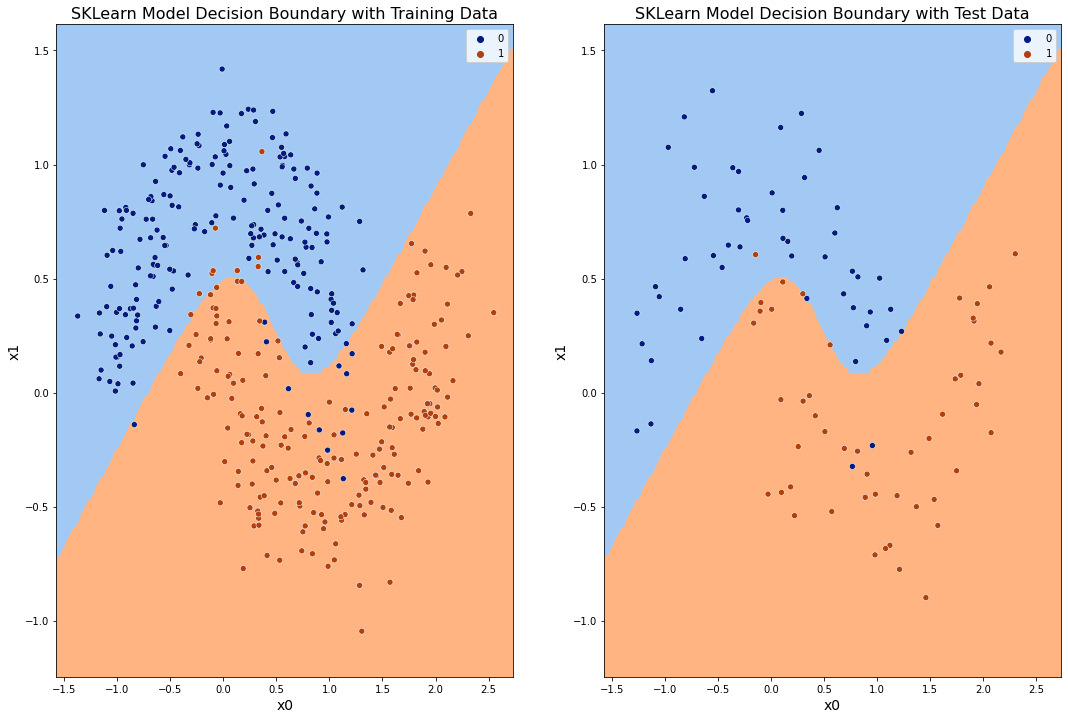

In [45]:
flex = 0.2
h=0.02
xx, yy = np.meshgrid(np.arange(x_train[:,0].min() - flex,
                               x_train[:,0].max() + flex, h),
                     np.arange(x_train[:,1].min() - flex,
                               x_train[:,1].max() + flex, h))
gridshape = xx.shape
grid = np.c_[xx.ravel(), yy.ravel()]
grids = {'ravel': grid, 'xx':xx, 'yy':yy}
gridpred = skmodel.predict(grids['ravel']).reshape(grids['xx'].shape)

bg_cmap = ListedColormap(sb.color_palette("pastel"),N=2)
dot_cmap = sb.color_palette("dark",2)
fig, ax = plt.subplots(1,2, figsize=(18,12))
ax[0].contourf(grids['xx'], grids['yy'], gridpred, cmap=bg_cmap)
ax[1].contourf(grids['xx'], grids['yy'], gridpred, cmap=bg_cmap)
sb.scatterplot(x=x_train[:,0],  y=x_train[:,1], hue=yy_train, ax=ax[0], palette=dot_cmap)
sb.scatterplot(x=x_test[:,0],  y=x_test[:,1], hue=yy_test, ax=ax[1], palette=dot_cmap)
ax[0].set_title("SKLearn Model Decision Boundary with Training Data", fontsize = 16)
ax[1].set_title("SKLearn Model Decision Boundary with Test Data", fontsize = 16)
ax[0].set_xlabel("x0", fontsize = 14)
ax[0].set_ylabel("x1", fontsize = 14)
ax[1].set_xlabel("x0", fontsize = 14)
ax[1].set_ylabel("x1", fontsize = 14)
None

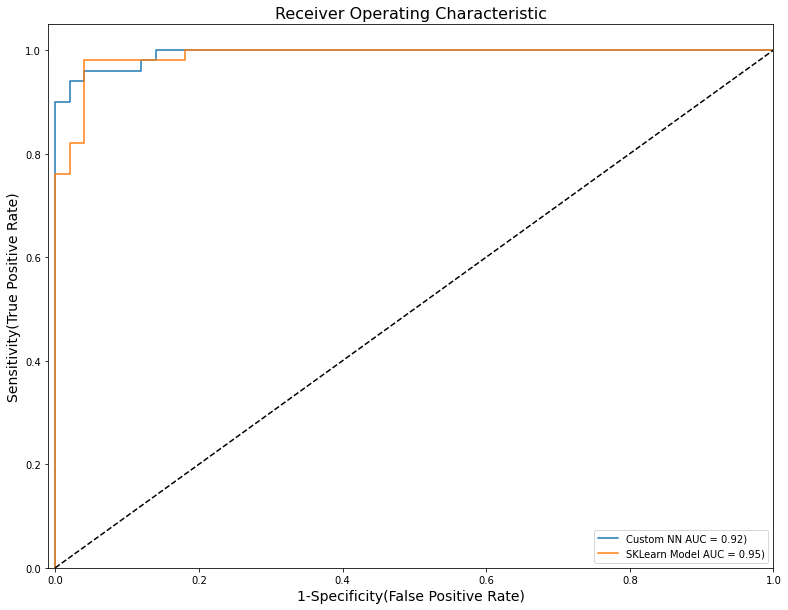

In [50]:
fpr_my, tpr_my, thresholds_my = roc_curve(yy_test, mynn.predict_proba(x_test, bias=True))
auc_my = roc_auc_score(yy_test, mynn.predict(x_test, bias=True))
fpr_sk, tpr_sk, thresholds_sk = roc_curve(yy_test, skmodel.predict_proba(x_test)[:,1])
auc_sk = roc_auc_score(yy_test,skmodel.predict(x_test))

fig,ax = plt.subplots(1, figsize=(13,10))
ax.plot(fpr_my, tpr_my, label='Custom NN AUC = %0.2f)' % auc_my)
ax.plot(fpr_sk, tpr_sk, label='SKLearn Model AUC = %0.2f)' % auc_sk)
ax.plot([0, 1], [0, 1],'r--', color='black')
ax.set_xlim([-0.01, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1-Specificity(False Positive Rate)', fontsize = 14)
ax.set_ylabel('Sensitivity(True Positive Rate)', fontsize = 14)
ax.set_title('Receiver Operating Characteristic', fontsize = 16)
ax.legend(loc="lower right")

**(c)** 

The models can be improved by considering other regularization methods like dropouts, other optimization techniques like momentum, Adam, having a batch_size > 1, as well as ensembling multiple models.